In [15]:
from os import sys
sys.path.append("..")

# ODE Solver

The following code demonstrates how to solve first and second order ODE's using my software.

# First Order

To solve a first order ODE of the form $\frac{dx}{dt} = x$ it must first be written as a python funtion as follows:


In [16]:
import numpy as np

def f(x, t):
    """
    Returns an array with one element.

    Parameters
    ----------
    x : float
        The value of x.
    t : float
        The time the solution must be evaluated at.

    Returns
    -------
    x : the value of x.
    """
    return x


Now the ODE can be solved using custom ODE solver. Within this solver it is possible to specify a particular solving method from Euler's method, Runge-Kutta 4th order and Heun 3rd order. The initial condition x0 at time t=0 must also be specified, alongside the start and end times and the step-size the solver is to take. Finally, it should be specified whether it is a first or second order ODE: 'True' if it is a system of equations, otherwise 'False'. In this example, Euler's method will be used.

In [17]:
import math
import numpy as np
from ODE import solve_ode

# Set up the initial conditions
x0 = 1.0
t_eval = np.linspace(0, 5, 101) # time points to evaluate the solution
max_step = 0.01 # maximum step size for the solver
method = 'euler' # numerical method for the solver
system = False # the ODE is not a system

# Solve the ODE using the solve_ode function
X = solve_ode(f, x0, t_eval, max_step, method, system)

To verify the numerical solution it can now be plotted against the true solution which is known to be:

$x(t)=e^t$

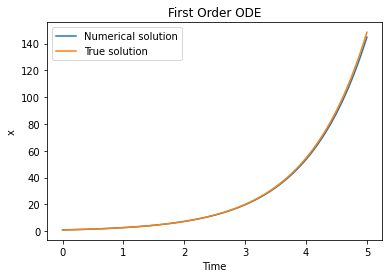

In [20]:
import matplotlib.pyplot as plt
def true_sol(t):
    """
    Returns the true solution of the first order ODE dx/dt = x.

    Parameters
    ----------
    t : numpy.ndarray
        An array containing the times the solution must be evaluated at.

    Returns
    -------
    numpy.ndarray
        An array containing the true solution of the first order ODE dx/dt = x.
    """
    return np.exp(t)

plt.plot(t_eval, X[:,0], label='Numerical solution')
plt.plot(t_eval, true_sol(t_eval), label='True solution')
plt.title('First Order ODE')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()


# Higher Order ODEs

To solve higher order ODEs it is necessary to first convert the ODE into a system of first order ODEs. For example, the second order ODE $\ddot{x} = -x$, can be written as $\dot{x} = y$ and $\dot{y} = -x$. This is coded as a function to be passed to solve_ode as follows:

In [21]:
def f_ddot(X, t):
    x, y = X
    dxdt = y
    dydt = -x
    return np.array([dxdt, dydt])


This can now be passed to solve_ode. I will demonstrate the solution using Runge-Kutta 4th Order solver this time. It should be noted that the parameter distinguishing between system of ODEs is now set to 'True'.


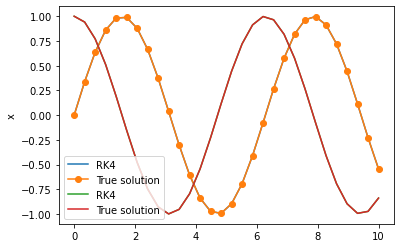

In [22]:


# Set up the initial conditions
x0 = [0, 1] # initial values of x and y
t_eval = np.linspace(0, 10, 30) # time points to evaluate the solution
max_step = 0.01 # maximum step size for the solver
method = 'RK4' # numerical method for the solver
system = True # the ODE is a system

# Solve the ODE using the solve_ode function
X = solve_ode(f_ddot, x0, t_eval, max_step, method, system)

def ddot_true_sol(t):
    x = np.sin(t)
    y = np.cos(t) 
    u = np.array([x, y])
    return u

def plot_system_ode(X,t_eval,true_sol):
    true_sol = np.array([true_sol(t) for t in t_eval])

    plt.plot(t_eval, X[0], label='RK4')
    plt.plot(t_eval, true_sol[:,0], 'o-',label='True solution')
    plt.plot(t_eval, X[1], label='RK4')
    plt.plot(t_eval, true_sol[:,1], label='True solution')

    plt.ylabel('x')
    plt.legend()
    plt.show()

plot_system_ode(X,t_eval,ddot_true_sol)

# Error Evaluation

To Evaluate the performance of the three different Numerical solvers I have implemented, a function calculating the error between the numerical and analytical solutions at varying timesteps has been created.


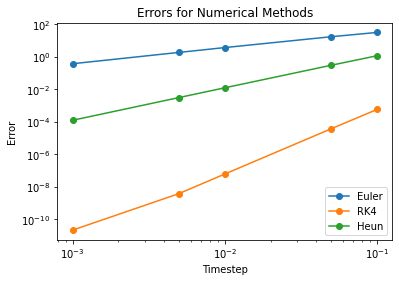

In [3]:
from plots import plot_error
from matplotlib import pyplot as plt
import numpy as np


def f(x, t):
    return x

# Define the true solution exp(t)
def true_sol(t):
    return np.exp(t)
x0 = 1  # initial condition
t0 = 0  # initial time
t1 = 5  # final time
dt_list = [0.1, 0.05, 0.01, 0.005, 0.001]  # list of timestep sizes to compare
args = ()  # empty tuple since there are no additional arguments for f
plot_error(f, true_sol, x0, t0, t1, dt_list, *args)

The above plot clearly demonstrates the superiority of the Runge-Kutta 4th order method, with the smallest error over a range of timesteps. 

# Numerical shooting

Please run the below code block initially.

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numdifftools as nd
from ODE import solve_ode

Before numerical_shooting is implemented, the predator-prey equations (Lokta-Voltera) are investigated. These take the form of: $\newline$
$\frac{dx}{dt} = x(1-x)-\frac{axy}{d+x}$

and

$\frac{dy}{dt}=by(1-\frac{y}{x})$

where a = 1, d = 0.1 and b = [0.1,0.5]

Below, the equations are plotted using a homemade plotting function. They first plot shows the differential equations for b<0.26. The second for b>0.26.

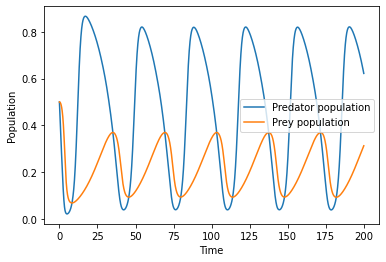

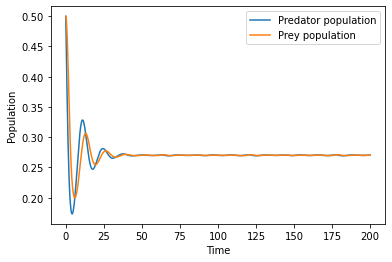

In [1]:
from shooting_plot import pred_prey_plot

def pred_prey_eq(X, pars):
  
    x = X[0]
    y = X[1]
    a, b, d = pars[0], pars[1], pars[2]
    dxdt = x * (1 - x) - (a * x * y) / (d + x)
    dydt = b * y * (1 - (y / x))
    return np.array([dxdt, dydt])

a = 1 
d= 0.1
bs = [0.1,0.5]

pred_prey_plot(a,d,bs)


As shown above for b<0.26 the solutions oscillate periodically and as b increases, x and y reach a stable equilibrium. 

I now implement a numerical shooting algorithm, which locates the initial conditions of the periodic orbit of the Predator-prey equations. For my shooting algorithm to work it is necessary to first define a phase condition. Ths phase condition has been determined to be $\frac{dx}{dt}(0)= 0$ from the course notes. I have parsed in the same arguments for the predator-prey equation as before, with b fixed as 0.1.

[ 0.81978612  0.16575823 34.06873819]


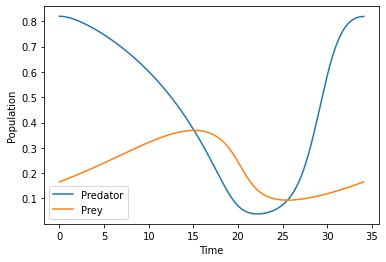

In [4]:
from shooting_plot import plot_solutions

def predator_prey(t, y, args = [1, 0.1, 0.1]):
    x = y[0]
    y = y[1]

    a = args[0]
    d = args[1]
    b = args[2]
     
    dxdt = x * (1 - x) - (a * x * y) / (d + x)
    dydt = b * y * (1 - (y / x))
    return np.array([dxdt, dydt])
    
def pc_predator_prey(u0, args = [1, 0.1, 0.1]):
    return predator_prey(0, u0, args = [1, 0.1, 0.1])[0]

# Define the initial guess for the shooting method
u0 = [0.8, 0.3,30]
plot_solutions(predator_prey,pc_predator_prey,u0,args=(), max_step=0.01)

The above code plots the isolated orbit found by the shooting algorithm.